In [11]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [12]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing
from deepinv.models.complex import to_complex_denoiser

In [13]:
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")

BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data"
SAVE_DIR = DATA_DIR / dt_string
FIGURE_DIR = DATA_DIR / "first_results"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "random").mkdir(parents=True, exist_ok=True)
Path(SAVE_DIR / "pseudorandom").mkdir(parents=True, exist_ok=True)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

print(SAVE_DIR)

data/20240703-112410


In [14]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 99, 99])

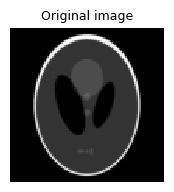

In [15]:
plot(x, titles="Original image")

In [16]:
# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

# Generate spectral methods results for pseudorandom phase retrieval

In [21]:
repeat = 10

start = 1
end = 299

res_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

In [22]:
for i in trange(start,end,2):
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=3,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio
        x_phase_spec = spectral_methods(y, physics,n_iter=2500)
        res_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_spec)
        # print the cosine similarity
        print(f"cosine similarity: {res_spec[(i - start)//2,j]}")

  0%|          | 0/149 [00:00<?, ?it/s]

cosine similarity: 0.004020581021904945
cosine similarity: 0.024705007672309875
cosine similarity: 0.006991297006607056
cosine similarity: 0.007514815777540207
cosine similarity: 0.009139616042375565
cosine similarity: 0.008753696456551552
cosine similarity: 0.0049534630961716175
cosine similarity: 0.007461365777999163
cosine similarity: 0.0010861825430765748


  1%|          | 1/149 [00:31<1:17:51, 31.56s/it]

cosine similarity: 0.014699650928378105
cosine similarity: 0.017311541363596916
cosine similarity: 0.01760968007147312
cosine similarity: 0.011049899272620678
cosine similarity: 0.02070680260658264
cosine similarity: 0.022316910326480865
cosine similarity: 0.016353923827409744
cosine similarity: 0.01536297146230936
cosine similarity: 0.024500779807567596
cosine similarity: 0.017848258838057518


  1%|▏         | 2/149 [01:03<1:17:34, 31.66s/it]

cosine similarity: 0.01481346320360899
cosine similarity: 0.01664573885500431
cosine similarity: 0.01441891584545374
cosine similarity: 0.017715100198984146
cosine similarity: 0.018360164016485214
cosine similarity: 0.019220301881432533
cosine similarity: 0.015109024941921234
cosine similarity: 0.01871672086417675
cosine similarity: 0.015232170931994915
cosine similarity: 0.01792222447693348


  2%|▏         | 3/149 [01:34<1:17:03, 31.66s/it]

cosine similarity: 0.025824081152677536
cosine similarity: 0.02244597300887108
cosine similarity: 0.022994576022028923
cosine similarity: 0.021370461210608482
cosine similarity: 0.02079007215797901
cosine similarity: 0.017430398613214493
cosine similarity: 0.02085825987160206
cosine similarity: 0.020685352385044098
cosine similarity: 0.024365339428186417
cosine similarity: 0.024440819397568703


  3%|▎         | 4/149 [02:06<1:16:37, 31.71s/it]

cosine similarity: 0.020230617374181747
cosine similarity: 0.021337734535336494
cosine similarity: 0.024129075929522514
cosine similarity: 0.022217512130737305
cosine similarity: 0.02265571802854538
cosine similarity: 0.02493331953883171
cosine similarity: 0.02093382552266121
cosine similarity: 0.021580852568149567
cosine similarity: 0.02070152945816517
cosine similarity: 0.019213838502764702


  3%|▎         | 5/149 [02:38<1:16:10, 31.74s/it]

cosine similarity: 0.02445278689265251
cosine similarity: 0.010480456054210663
cosine similarity: 0.025979310274124146
cosine similarity: 0.01931297779083252
cosine similarity: 0.02299610897898674
cosine similarity: 0.02458489127457142
cosine similarity: 0.02315676212310791
cosine similarity: 0.019929872825741768
cosine similarity: 0.032355085015296936
cosine similarity: 0.0212609451264143


  4%|▍         | 6/149 [03:10<1:15:37, 31.73s/it]

cosine similarity: 0.024224815890192986
cosine similarity: 0.01993749476969242
cosine similarity: 0.024759091436862946
cosine similarity: 0.019658640027046204
cosine similarity: 0.024349166080355644
cosine similarity: 0.02381950058043003
cosine similarity: 0.02115001529455185
cosine similarity: 0.02097250148653984
cosine similarity: 0.02212592400610447
cosine similarity: 0.02236422896385193


  5%|▍         | 7/149 [03:42<1:15:11, 31.77s/it]

cosine similarity: 0.02382056787610054
cosine similarity: 0.018607251346111298
cosine similarity: 0.025301115587353706
cosine similarity: 0.02268359810113907
cosine similarity: 0.025489814579486847
cosine similarity: 0.02701409161090851
cosine similarity: 0.026012901216745377
cosine similarity: 0.01900614984333515
cosine similarity: 0.02620924636721611
cosine similarity: 0.021671051159501076


  5%|▌         | 8/149 [04:13<1:14:41, 31.78s/it]

cosine similarity: 0.027202079072594643
cosine similarity: 0.029891734942793846
cosine similarity: 0.022825051099061966
cosine similarity: 0.02130710892379284
cosine similarity: 0.024646040052175522
cosine similarity: 0.019514838233590126
cosine similarity: 0.02375313639640808
cosine similarity: 0.027496272698044777
cosine similarity: 0.024687545374035835
cosine similarity: 0.026048550382256508


  6%|▌         | 9/149 [04:45<1:14:16, 31.83s/it]

cosine similarity: 0.027204066514968872
cosine similarity: 0.02393302135169506
cosine similarity: 0.026157744228839874
cosine similarity: 0.023777835071086884
cosine similarity: 0.022304095327854156
cosine similarity: 0.027524104341864586
cosine similarity: 0.024895742535591125
cosine similarity: 0.02314726635813713
cosine similarity: 0.024164199829101562
cosine similarity: 0.02332628145813942


  7%|▋         | 10/149 [05:17<1:13:37, 31.78s/it]

cosine similarity: 0.025092650204896927
cosine similarity: 0.025755250826478004
cosine similarity: 0.029968135058879852
cosine similarity: 0.025164790451526642
cosine similarity: 0.02350168116390705
cosine similarity: 0.014019686728715897
cosine similarity: 0.027751561254262924
cosine similarity: 0.019336193799972534
cosine similarity: 0.0258820541203022
cosine similarity: 0.02594657987356186


  7%|▋         | 11/149 [05:49<1:13:09, 31.81s/it]

cosine similarity: 0.028002506121993065
cosine similarity: 0.022309888154268265
cosine similarity: 0.028883585706353188
cosine similarity: 0.031394194811582565
cosine similarity: 0.024414854124188423
cosine similarity: 0.030942097306251526
cosine similarity: 0.027597568929195404
cosine similarity: 0.030371231958270073
cosine similarity: 0.029057063162326813
cosine similarity: 0.035029131919145584


  8%|▊         | 12/149 [06:21<1:12:44, 31.86s/it]

cosine similarity: 0.027791090309619904
cosine similarity: 0.02659083716571331
cosine similarity: 0.03160768747329712
cosine similarity: 0.029820825904607773
cosine similarity: 0.027409011498093605
cosine similarity: 0.019281087443232536
cosine similarity: 0.024685228243470192
cosine similarity: 0.0275372676551342
cosine similarity: 0.02661721594631672
cosine similarity: 0.023127391934394836


  9%|▊         | 13/149 [06:53<1:12:11, 31.85s/it]

cosine similarity: 0.02940148301422596
cosine similarity: 0.004407075699418783
cosine similarity: 0.024711107835173607
cosine similarity: 0.026828529313206673
cosine similarity: 0.016328394412994385
cosine similarity: 0.012190373614430428
cosine similarity: 0.022898515686392784
cosine similarity: 0.02532881498336792
cosine similarity: 0.029220949858427048
cosine similarity: 0.025614963844418526


  9%|▉         | 14/149 [07:25<1:11:38, 31.84s/it]

cosine similarity: 0.0280968826264143
cosine similarity: 0.030323149636387825
cosine similarity: 0.027308490127325058
cosine similarity: 0.02896367758512497
cosine similarity: 0.026609821245074272
cosine similarity: 0.02335778996348381
cosine similarity: 0.027168335393071175
cosine similarity: 0.033378925174474716
cosine similarity: 0.024448320269584656
cosine similarity: 0.027409382164478302


 10%|█         | 15/149 [07:56<1:11:09, 31.86s/it]

cosine similarity: 0.023274676874279976
cosine similarity: 0.02671768330037594
cosine similarity: 0.0270348209887743
cosine similarity: 0.02742156945168972
cosine similarity: 0.026425350457429886
cosine similarity: 0.030031748116016388
cosine similarity: 0.02685626596212387
cosine similarity: 0.04204590991139412
cosine similarity: 0.029260460287332535
cosine similarity: 0.027416685596108437


 11%|█         | 16/149 [08:28<1:10:33, 31.83s/it]

cosine similarity: 0.034125059843063354
cosine similarity: 0.0255278367549181
cosine similarity: 0.03620972856879234
cosine similarity: 0.02849116548895836
cosine similarity: 0.03753168135881424
cosine similarity: 0.01942000724375248
cosine similarity: 0.025868164375424385
cosine similarity: 0.03371117636561394
cosine similarity: 0.030049994587898254
cosine similarity: 0.030123582109808922


 11%|█▏        | 17/149 [09:00<1:10:10, 31.89s/it]

cosine similarity: 0.03832860291004181
cosine similarity: 0.028216660022735596
cosine similarity: 0.029609525576233864
cosine similarity: 0.028291894122958183
cosine similarity: 0.029798930510878563
cosine similarity: 0.028680911287665367
cosine similarity: 0.0319177508354187
cosine similarity: 0.025664543733000755
cosine similarity: 0.025023415684700012
cosine similarity: 0.02973637729883194


 12%|█▏        | 18/149 [09:32<1:09:44, 31.95s/it]

cosine similarity: 0.02973131835460663
cosine similarity: 0.027974534779787064
cosine similarity: 0.026738805696368217
cosine similarity: 0.02494008094072342
cosine similarity: 0.02566538378596306
cosine similarity: 0.024369224905967712
cosine similarity: 0.027749016880989075
cosine similarity: 0.027689071372151375
cosine similarity: 0.03062141127884388
cosine similarity: 0.02873900532722473


 13%|█▎        | 19/149 [10:04<1:09:15, 31.97s/it]

cosine similarity: 0.03105294331908226
cosine similarity: 0.02936490997672081
cosine similarity: 0.027142642065882683
cosine similarity: 0.029477473348379135
cosine similarity: 0.025698140263557434
cosine similarity: 0.03030744008719921
cosine similarity: 0.02575010620057583
cosine similarity: 0.027297282591462135
cosine similarity: 0.028332063928246498
cosine similarity: 0.031094485893845558


 13%|█▎        | 20/149 [10:36<1:08:47, 31.99s/it]

cosine similarity: 0.007388833910226822
cosine similarity: 0.03055449388921261
cosine similarity: 0.031742095947265625
cosine similarity: 0.032748911529779434
cosine similarity: 0.030179446563124657
cosine similarity: 0.028599077835679054
cosine similarity: 0.029814306646585464
cosine similarity: 0.030161308124661446
cosine similarity: 0.027374321594834328
cosine similarity: 0.027968091890215874


 14%|█▍        | 21/149 [11:08<1:08:16, 32.00s/it]

cosine similarity: 0.032347455620765686
cosine similarity: 0.02921353094279766
cosine similarity: 0.0054457904770970345
cosine similarity: 0.012550855055451393
cosine similarity: 0.028544027358293533
cosine similarity: 0.030742043629288673
cosine similarity: 0.022985998541116714
cosine similarity: 0.030790623277425766
cosine similarity: 0.02888309583067894
cosine similarity: 0.029074210673570633


 15%|█▍        | 22/149 [11:41<1:07:51, 32.06s/it]

cosine similarity: 0.036576047539711
cosine similarity: 0.029118895530700684
cosine similarity: 0.028566256165504456
cosine similarity: 0.02920614555478096
cosine similarity: 0.021341361105442047
cosine similarity: 0.02754858136177063
cosine similarity: 0.027341503649950027
cosine similarity: 0.032708585262298584
cosine similarity: 0.02608003281056881
cosine similarity: 0.028800196945667267


 15%|█▌        | 23/149 [12:13<1:07:25, 32.11s/it]

cosine similarity: 0.03619543835520744
cosine similarity: 0.024381248280405998
cosine similarity: 0.019079506397247314
cosine similarity: 0.030467180535197258
cosine similarity: 0.018727315589785576
cosine similarity: 0.031255800276994705
cosine similarity: 0.03363505005836487
cosine similarity: 0.03144555911421776
cosine similarity: 0.031201675534248352
cosine similarity: 0.02912266179919243


 16%|█▌        | 24/149 [12:45<1:06:52, 32.10s/it]

cosine similarity: 0.0356207974255085
cosine similarity: 0.03211735561490059
cosine similarity: 0.028104333207011223
cosine similarity: 0.03616176173090935
cosine similarity: 0.02884349226951599
cosine similarity: 0.020662739872932434
cosine similarity: 0.029247652739286423
cosine similarity: 0.01961032673716545
cosine similarity: 0.02666257694363594
cosine similarity: 0.027076348662376404


 17%|█▋        | 25/149 [13:17<1:06:27, 32.15s/it]

cosine similarity: 0.029632970690727234
cosine similarity: 0.028102682903409004
cosine similarity: 0.030548594892024994
cosine similarity: 0.028340989723801613
cosine similarity: 0.038114845752716064
cosine similarity: 0.027097992599010468
cosine similarity: 0.031788259744644165
cosine similarity: 0.030474292114377022
cosine similarity: 0.030246542766690254
cosine similarity: 0.025970008224248886


 17%|█▋        | 26/149 [13:49<1:05:52, 32.13s/it]

cosine similarity: 0.028123099356889725
cosine similarity: 0.02744434028863907
cosine similarity: 0.02814023196697235
cosine similarity: 0.029857749119400978
cosine similarity: 0.02904830127954483
cosine similarity: 0.03446463868021965
cosine similarity: 0.032345447689294815
cosine similarity: 0.033262163400650024
cosine similarity: 0.028324030339717865
cosine similarity: 0.029622333124279976


 18%|█▊        | 27/149 [14:21<1:05:19, 32.13s/it]

cosine similarity: 0.031121695414185524
cosine similarity: 0.030587423592805862
cosine similarity: 0.03130726143717766
cosine similarity: 0.03202755004167557
cosine similarity: 0.027888108044862747
cosine similarity: 0.029898297041654587
cosine similarity: 0.03158484399318695
cosine similarity: 0.029726093634963036
cosine similarity: 0.022516615688800812
cosine similarity: 0.02962210215628147


 19%|█▉        | 28/149 [14:53<1:04:47, 32.13s/it]

cosine similarity: 0.030415624380111694
cosine similarity: 0.011099085211753845
cosine similarity: 0.027827253565192223
cosine similarity: 0.03129343315958977
cosine similarity: 0.0336800217628479
cosine similarity: 0.027851372957229614
cosine similarity: 0.03551701828837395
cosine similarity: 0.02707802504301071
cosine similarity: 0.007655942812561989
cosine similarity: 0.027958929538726807


 19%|█▉        | 29/149 [15:26<1:04:17, 32.14s/it]

cosine similarity: 0.03367861360311508
cosine similarity: 0.020311538130044937
cosine similarity: 0.03649766370654106
cosine similarity: 0.03206193074584007
cosine similarity: 0.023165294900536537
cosine similarity: 0.03347977623343468
cosine similarity: 0.025797922164201736
cosine similarity: 0.03172685578465462
cosine similarity: 0.031061116605997086
cosine similarity: 0.024707593023777008


 20%|██        | 30/149 [15:58<1:03:53, 32.21s/it]

cosine similarity: 0.030678825452923775
cosine similarity: 0.03221060708165169
cosine similarity: 0.023797374218702316
cosine similarity: 0.029508383944630623
cosine similarity: 0.00435266038402915
cosine similarity: 0.03632098063826561
cosine similarity: 0.02967079170048237
cosine similarity: 0.034881383180618286
cosine similarity: 0.027655020356178284
cosine similarity: 0.02972814254462719


 21%|██        | 31/149 [16:30<1:03:21, 32.22s/it]

cosine similarity: 0.02630475163459778
cosine similarity: 0.03456270322203636
cosine similarity: 0.03348518908023834
cosine similarity: 0.030130984261631966
cosine similarity: 0.03153965249657631
cosine similarity: 0.04559367522597313
cosine similarity: 0.03031369484961033
cosine similarity: 0.037225063890218735
cosine similarity: 0.030239522457122803
cosine similarity: 0.010318988002836704


 21%|██▏       | 32/149 [17:02<1:02:46, 32.19s/it]

cosine similarity: 0.03200215473771095
cosine similarity: 0.02526935748755932
cosine similarity: 0.030438808724284172
cosine similarity: 0.036841150373220444
cosine similarity: 0.026896363124251366
cosine similarity: 0.030406054109334946
cosine similarity: 0.028822699561715126
cosine similarity: 0.030801920220255852
cosine similarity: 0.02904515340924263
cosine similarity: 0.03279971331357956


 22%|██▏       | 33/149 [17:35<1:02:19, 32.23s/it]

cosine similarity: 0.032679665833711624
cosine similarity: 0.034311238676309586
cosine similarity: 0.014067891985177994
cosine similarity: 0.033492300659418106
cosine similarity: 0.022954853251576424
cosine similarity: 0.036700911819934845
cosine similarity: 0.030151166021823883
cosine similarity: 0.015483108349144459
cosine similarity: 0.02655472792685032
cosine similarity: 0.021038789302110672


 23%|██▎       | 34/149 [18:07<1:01:45, 32.22s/it]

cosine similarity: 0.031880881637334824
cosine similarity: 0.033172253519296646
cosine similarity: 0.02994437888264656
cosine similarity: 0.029653113335371017
cosine similarity: 0.02169046737253666
cosine similarity: 0.028811883181333542
cosine similarity: 0.0315660759806633
cosine similarity: 0.03497349098324776
cosine similarity: 0.02830691821873188
cosine similarity: 0.03263209015130997


 23%|██▎       | 35/149 [18:39<1:01:16, 32.25s/it]

cosine similarity: 0.021703029051423073
cosine similarity: 0.031247427687048912
cosine similarity: 0.02741583064198494
cosine similarity: 0.030368350446224213
cosine similarity: 0.03265475109219551
cosine similarity: 0.02828414924442768
cosine similarity: 0.030905326828360558
cosine similarity: 0.025469372048974037
cosine similarity: 0.028336359187960625
cosine similarity: 0.031408462673425674


 24%|██▍       | 36/149 [19:12<1:00:45, 32.26s/it]

cosine similarity: 0.028359292075037956
cosine similarity: 0.02521156333386898
cosine similarity: 0.03453901410102844
cosine similarity: 0.020043786615133286
cosine similarity: 0.025521453469991684
cosine similarity: 0.025988908484578133
cosine similarity: 0.03230791166424751
cosine similarity: 0.033819351345300674
cosine similarity: 0.029107458889484406
cosine similarity: 0.03070976585149765


 25%|██▍       | 37/149 [19:44<1:00:15, 32.28s/it]

cosine similarity: 0.012655824422836304
cosine similarity: 0.03241128474473953
cosine similarity: 0.03057105280458927
cosine similarity: 0.03254168480634689
cosine similarity: 0.031321924179792404
cosine similarity: 0.025112587958574295
cosine similarity: 0.0383666567504406
cosine similarity: 0.029847724363207817
cosine similarity: 0.028896905481815338
cosine similarity: 0.024562712758779526


 26%|██▌       | 38/149 [20:16<59:45, 32.31s/it]  

cosine similarity: 0.034304145723581314
cosine similarity: 0.0225374773144722
cosine similarity: 0.03333545848727226
cosine similarity: 0.028987985104322433
cosine similarity: 0.011711428873240948
cosine similarity: 0.03246074914932251
cosine similarity: 0.03316983953118324
cosine similarity: 0.03378644585609436
cosine similarity: 0.0410587452352047
cosine similarity: 0.03511062636971474


 26%|██▌       | 39/149 [20:48<59:11, 32.29s/it]

cosine similarity: 0.029995521530508995
cosine similarity: 0.04306233301758766
cosine similarity: 0.029055658727884293
cosine similarity: 0.032267481088638306
cosine similarity: 0.030506661161780357
cosine similarity: 0.024433329701423645
cosine similarity: 0.031001269817352295
cosine similarity: 0.002165508223697543
cosine similarity: 0.02609356865286827
cosine similarity: 0.03040139563381672


 27%|██▋       | 40/149 [21:21<58:38, 32.28s/it]

cosine similarity: 0.03152690827846527
cosine similarity: 0.023143243044614792
cosine similarity: 0.03052097000181675
cosine similarity: 0.012143530882894993
cosine similarity: 0.03637036681175232
cosine similarity: 0.03943191468715668
cosine similarity: 0.03236847743391991
cosine similarity: 0.03003566712141037
cosine similarity: 0.027982888743281364
cosine similarity: 0.04185710847377777


 28%|██▊       | 41/149 [21:53<58:08, 32.30s/it]

cosine similarity: 0.03856130316853523
cosine similarity: 0.03536147624254227
cosine similarity: 0.029405085369944572
cosine similarity: 0.03099830634891987
cosine similarity: 0.031449493020772934
cosine similarity: 0.036246586591005325
cosine similarity: 0.030342092737555504
cosine similarity: 0.03603590279817581
cosine similarity: 0.03219698742032051
cosine similarity: 0.03474905714392662


 28%|██▊       | 42/149 [22:25<57:33, 32.27s/it]

cosine similarity: 0.029540665447711945
cosine similarity: 0.03087315894663334
cosine similarity: 0.03646373376250267
cosine similarity: 0.023970885202288628
cosine similarity: 0.033079154789447784
cosine similarity: 0.03315578028559685
cosine similarity: 0.030923550948500633
cosine similarity: 0.04025357961654663
cosine similarity: 0.03277341648936272
cosine similarity: 0.03140941634774208


 29%|██▉       | 43/149 [22:58<56:59, 32.26s/it]

cosine similarity: 0.033584099262952805
cosine similarity: 0.03624606505036354
cosine similarity: 0.022320015355944633
cosine similarity: 0.03315875679254532
cosine similarity: 0.013586870394647121
cosine similarity: 0.028911873698234558
cosine similarity: 0.031224392354488373
cosine similarity: 0.03504548221826553
cosine similarity: 0.03254685550928116
cosine similarity: 0.030064648017287254


 30%|██▉       | 44/149 [23:30<56:35, 32.34s/it]

cosine similarity: 0.03293463960289955
cosine similarity: 0.03544969856739044
cosine similarity: 0.026752052828669548
cosine similarity: 0.02493126504123211
cosine similarity: 0.030089812353253365
cosine similarity: 0.03193138167262077
cosine similarity: 0.036567773669958115
cosine similarity: 0.030948152765631676
cosine similarity: 0.032013267278671265
cosine similarity: 0.03400769084692001


 30%|███       | 45/149 [24:02<56:06, 32.37s/it]

cosine similarity: 0.024017922580242157
cosine similarity: 0.030500737950205803
cosine similarity: 0.01678125374019146
cosine similarity: 0.03380697965621948
cosine similarity: 0.03321047127246857
cosine similarity: 0.033399682492017746
cosine similarity: 0.026387885212898254
cosine similarity: 0.03879445046186447
cosine similarity: 0.03374626860022545
cosine similarity: 0.026625845581293106


 31%|███       | 46/149 [24:35<55:39, 32.42s/it]

cosine similarity: 0.02154918573796749
cosine similarity: 0.043594326823949814
cosine similarity: 0.03218362107872963
cosine similarity: 0.02055097371339798
cosine similarity: 0.03284623846411705
cosine similarity: 0.024829527363181114
cosine similarity: 0.03292105346918106
cosine similarity: 0.032851528376340866
cosine similarity: 0.033494677394628525
cosine similarity: 0.03239501640200615


 32%|███▏      | 47/149 [25:07<55:05, 32.41s/it]

cosine similarity: 0.04534473642706871
cosine similarity: 0.031792353838682175
cosine similarity: 0.027735304087400436
cosine similarity: 0.027161287143826485
cosine similarity: 0.0322573222219944
cosine similarity: 0.03265758603811264
cosine similarity: 0.031349677592515945
cosine similarity: 0.03133260831236839
cosine similarity: 0.03779911622405052
cosine similarity: 0.027111629024147987


 32%|███▏      | 48/149 [25:40<54:30, 32.38s/it]

cosine similarity: 0.03061285801231861
cosine similarity: 0.03311053663492203
cosine similarity: 0.033029329031705856
cosine similarity: 0.031534142792224884
cosine similarity: 0.031771138310432434
cosine similarity: 0.0356174111366272
cosine similarity: 0.031030617654323578
cosine similarity: 0.031609177589416504
cosine similarity: 0.03125569969415665
cosine similarity: 0.033093906939029694


 33%|███▎      | 49/149 [26:12<54:00, 32.41s/it]

cosine similarity: 0.007570057176053524
cosine similarity: 0.018027571961283684
cosine similarity: 0.030833860859274864
cosine similarity: 0.03832363709807396
cosine similarity: 0.03512612730264664
cosine similarity: 0.026200557127594948
cosine similarity: 0.03479168564081192
cosine similarity: 0.034733161330223083
cosine similarity: 0.03383106365799904
cosine similarity: 0.03116009756922722


 34%|███▎      | 50/149 [26:42<52:05, 31.58s/it]

cosine similarity: 0.04260895773768425
cosine similarity: 0.039318475872278214
cosine similarity: 0.012761421501636505
cosine similarity: 0.036696963012218475
cosine similarity: 0.03331584855914116
cosine similarity: 0.0443691723048687
cosine similarity: 0.026650305837392807
cosine similarity: 0.02281150221824646
cosine similarity: 0.0367160402238369
cosine similarity: 0.03535470366477966


 34%|███▍      | 51/149 [27:22<55:53, 34.22s/it]

cosine similarity: 0.0207326989620924
cosine similarity: 0.011800797656178474
cosine similarity: 0.018811305984854698
cosine similarity: 0.02639974094927311
cosine similarity: 0.024767087772488594
cosine similarity: 0.03516455367207527
cosine similarity: 0.0373196005821228
cosine similarity: 0.04660612344741821
cosine similarity: 0.03139878064393997
cosine similarity: 0.03200147673487663


 35%|███▍      | 52/149 [28:03<58:32, 36.21s/it]

cosine similarity: 0.03492814302444458
cosine similarity: 0.04252437502145767
cosine similarity: 0.03755643963813782
cosine similarity: 0.03139311447739601
cosine similarity: 0.046717751771211624
cosine similarity: 0.024738816544413567
cosine similarity: 0.017245691269636154
cosine similarity: 0.03890375420451164
cosine similarity: 0.03163215517997742
cosine similarity: 0.022601589560508728


 36%|███▌      | 53/149 [28:40<58:23, 36.49s/it]

cosine similarity: 0.03103259764611721
cosine similarity: 0.0440620556473732
cosine similarity: 0.03102804906666279
cosine similarity: 0.02702239528298378
cosine similarity: 0.03495373949408531
cosine similarity: 0.03237767890095711
cosine similarity: 0.02695371024310589
cosine similarity: 0.03390689566731453
cosine similarity: 0.042502790689468384
cosine similarity: 0.02058950625360012


 36%|███▌      | 54/149 [29:22<1:00:08, 37.99s/it]

cosine similarity: 0.017774704843759537
cosine similarity: 0.028376659378409386
cosine similarity: 0.03280995413661003
cosine similarity: 0.05885683745145798
cosine similarity: 0.01848425716161728
cosine similarity: 0.022632041946053505
cosine similarity: 0.036116231232881546
cosine similarity: 0.023852139711380005
cosine similarity: 0.0065621789544820786
cosine similarity: 0.04578385129570961


 37%|███▋      | 55/149 [30:04<1:01:21, 39.16s/it]

cosine similarity: 0.05584659427404404
cosine similarity: 0.016297752037644386
cosine similarity: 0.04514198377728462
cosine similarity: 0.011458941735327244
cosine similarity: 0.0428389236330986
cosine similarity: 0.014900131151080132
cosine similarity: 0.03617606684565544
cosine similarity: 0.02256411500275135
cosine similarity: 0.043155696243047714
cosine similarity: 0.03601338714361191


 38%|███▊      | 56/149 [31:17<1:16:31, 49.37s/it]

cosine similarity: 0.039239123463630676
cosine similarity: 0.01667684316635132
cosine similarity: 0.010342373512685299
cosine similarity: 0.055252328515052795
cosine similarity: 0.05558269843459129
cosine similarity: 0.048661455512046814
cosine similarity: 0.037919919937849045
cosine similarity: 0.04042718932032585
cosine similarity: 0.018143657594919205
cosine similarity: 0.03259811922907829


 38%|███▊      | 57/149 [31:59<1:12:31, 47.30s/it]

cosine similarity: 0.06363820284605026
cosine similarity: 0.06622184813022614
cosine similarity: 0.04339813441038132
cosine similarity: 0.07058165967464447
cosine similarity: 0.0727735087275505
cosine similarity: 0.03684024512767792
cosine similarity: 0.030690936371684074
cosine similarity: 0.03535297140479088
cosine similarity: 0.07435402274131775
cosine similarity: 0.036941882222890854


 39%|███▉      | 58/149 [32:53<1:14:49, 49.34s/it]

cosine similarity: 0.04103906825184822
cosine similarity: 0.055803555995225906
cosine similarity: 0.07442504167556763
cosine similarity: 0.06091555580496788
cosine similarity: 0.06750280410051346
cosine similarity: 0.05226676166057587
cosine similarity: 0.0608212873339653
cosine similarity: 0.04467432573437691
cosine similarity: 0.031906113028526306
cosine similarity: 0.0589720644056797


 40%|███▉      | 59/149 [33:29<1:07:51, 45.24s/it]

cosine similarity: 0.06569743156433105
cosine similarity: 0.03490723669528961
cosine similarity: 0.06002858281135559
cosine similarity: 0.04845680668950081
cosine similarity: 0.03058047592639923
cosine similarity: 0.01117234118282795
cosine similarity: 0.04902680218219757
cosine similarity: 0.06771166622638702
cosine similarity: 0.04191454499959946
cosine similarity: 0.0758601576089859


 40%|████      | 60/149 [34:16<1:07:41, 45.63s/it]

cosine similarity: 0.039604946970939636
cosine similarity: 0.038049545139074326
cosine similarity: 0.03787149861454964
cosine similarity: 0.06820055842399597
cosine similarity: 0.04164222255349159
cosine similarity: 0.04406999796628952
cosine similarity: 0.05108289420604706
cosine similarity: 0.034642916172742844
cosine similarity: 0.08913984149694443
cosine similarity: 0.05748601630330086


 41%|████      | 61/149 [34:52<1:02:45, 42.79s/it]

cosine similarity: 0.07622901350259781
cosine similarity: 0.05839909240603447
cosine similarity: 0.09095308184623718
cosine similarity: 0.06321080029010773
cosine similarity: 0.03899426385760307
cosine similarity: 0.0454990454018116
cosine similarity: 0.018094602972269058
cosine similarity: 0.03815343603491783
cosine similarity: 0.0193355493247509
cosine similarity: 0.027767697349190712


 42%|████▏     | 62/149 [36:14<1:19:22, 54.74s/it]

cosine similarity: 0.04979852959513664
cosine similarity: 0.006560270208865404
cosine similarity: 0.09459146112203598
cosine similarity: 0.07014722377061844
cosine similarity: 0.0210619755089283
cosine similarity: 0.0855131521821022
cosine similarity: 0.07103355973958969
cosine similarity: 0.0776720941066742
cosine similarity: 0.024841241538524628
cosine similarity: 0.03452606871724129


 42%|████▏     | 63/149 [36:51<1:10:53, 49.46s/it]

cosine similarity: 0.04015583544969559
cosine similarity: 0.03779106214642525
cosine similarity: 0.024897964671254158
cosine similarity: 0.08285519480705261
cosine similarity: 0.1096225157380104
cosine similarity: 0.05737464129924774
cosine similarity: 0.04452482983469963
cosine similarity: 0.037265025079250336
cosine similarity: 0.018743911758065224
cosine similarity: 0.05706672742962837


 43%|████▎     | 64/149 [37:37<1:08:26, 48.31s/it]

cosine similarity: 0.05440300703048706
cosine similarity: 0.06908901780843735
cosine similarity: 0.05579850450158119
cosine similarity: 0.013685829006135464
cosine similarity: 0.0566556490957737
cosine similarity: 0.06213914230465889
cosine similarity: 0.04848051816225052
cosine similarity: 0.08748049288988113
cosine similarity: 0.015269226394593716
cosine similarity: 0.12189508229494095


 44%|████▎     | 65/149 [39:06<1:24:29, 60.35s/it]

cosine similarity: 0.09860620647668839
cosine similarity: 0.03645496815443039
cosine similarity: 0.1321813464164734
cosine similarity: 0.045171502977609634
cosine similarity: 0.08561541885137558
cosine similarity: 0.08443713188171387
cosine similarity: 0.009357795119285583
cosine similarity: 0.05274130776524544
cosine similarity: 0.10008510947227478
cosine similarity: 0.03735903650522232


 44%|████▍     | 66/149 [39:53<1:18:10, 56.52s/it]

cosine similarity: 0.02845914289355278
cosine similarity: 0.16998521983623505
cosine similarity: 0.08422952890396118
cosine similarity: 0.1320316344499588
cosine similarity: 0.04532572254538536
cosine similarity: 0.05707305669784546
cosine similarity: 0.09245818108320236
cosine similarity: 0.1075109988451004
cosine similarity: 0.10769400000572205
cosine similarity: 0.09027406573295593


 45%|████▍     | 67/149 [40:44<1:15:02, 54.91s/it]

cosine similarity: 0.07754756510257721
cosine similarity: 0.08454630523920059
cosine similarity: 0.07433576136827469
cosine similarity: 0.06950034946203232
cosine similarity: 0.11676735430955887
cosine similarity: 0.18634989857673645
cosine similarity: 0.04640477895736694
cosine similarity: 0.14271749556064606
cosine similarity: 0.11277318000793457
cosine similarity: 0.12136483192443848


 46%|████▌     | 68/149 [41:23<1:07:45, 50.19s/it]

cosine similarity: 0.07812460511922836
cosine similarity: 0.08248310536146164
cosine similarity: 0.17224515974521637
cosine similarity: 0.055184751749038696
cosine similarity: 0.1277308315038681
cosine similarity: 0.04124607890844345
cosine similarity: 0.15824761986732483
cosine similarity: 0.10777506977319717
cosine similarity: 0.16728223860263824
cosine similarity: 0.13227185606956482


 46%|████▋     | 69/149 [42:14<1:06:58, 50.24s/it]

cosine similarity: 0.08294037729501724
cosine similarity: 0.16093555092811584
cosine similarity: 0.15647372603416443
cosine similarity: 0.09170428663492203
cosine similarity: 0.092995285987854
cosine similarity: 0.14006423950195312
cosine similarity: 0.15690569579601288
cosine similarity: 0.17300719022750854
cosine similarity: 0.26808327436447144
cosine similarity: 0.09716172516345978


 47%|████▋     | 70/149 [43:04<1:05:56, 50.09s/it]

cosine similarity: 0.11221244931221008
cosine similarity: 0.2361036092042923
cosine similarity: 0.2323930859565735
cosine similarity: 0.09723883122205734
cosine similarity: 0.25799861550331116
cosine similarity: 0.06295386701822281
cosine similarity: 0.09515508264303207
cosine similarity: 0.2717132270336151
cosine similarity: 0.15065473318099976
cosine similarity: 0.16184750199317932


 48%|████▊     | 71/149 [44:45<1:25:05, 65.45s/it]

cosine similarity: 0.24369943141937256
cosine similarity: 0.16522599756717682
cosine similarity: 0.16993750631809235
cosine similarity: 0.3427446186542511
cosine similarity: 0.19074402749538422
cosine similarity: 0.3474702835083008
cosine similarity: 0.15420952439308167
cosine similarity: 0.19453155994415283
cosine similarity: 0.13075129687786102
cosine similarity: 0.23644796013832092


 48%|████▊     | 72/149 [45:25<1:14:17, 57.90s/it]

cosine similarity: 0.3528892695903778
cosine similarity: 0.36685341596603394
cosine similarity: 0.2535863518714905
cosine similarity: 0.43652230501174927
cosine similarity: 0.2578895688056946
cosine similarity: 0.1567491739988327
cosine similarity: 0.2237965166568756
cosine similarity: 0.05841609090566635
cosine similarity: 0.35279855132102966
cosine similarity: 0.34176188707351685


 49%|████▉     | 73/149 [46:42<1:20:37, 63.65s/it]

cosine similarity: 0.34300434589385986
cosine similarity: 0.4008806049823761
cosine similarity: 0.10232123732566833
cosine similarity: 0.37740710377693176
cosine similarity: 0.39465102553367615
cosine similarity: 0.37263667583465576
cosine similarity: 0.43459197878837585
cosine similarity: 0.2721131145954132
cosine similarity: 0.45797616243362427
cosine similarity: 0.3959468603134155


 50%|████▉     | 74/149 [47:23<1:11:10, 56.94s/it]

cosine similarity: 0.22346776723861694
cosine similarity: 0.492738276720047
cosine similarity: 0.24448728561401367
cosine similarity: 0.4149409532546997
cosine similarity: 0.3778674006462097
cosine similarity: 0.33794882893562317
cosine similarity: 0.46352800726890564
cosine similarity: 0.3925469219684601
cosine similarity: 0.4694782793521881
cosine similarity: 0.4718707501888275


 50%|█████     | 75/149 [48:17<1:08:52, 55.85s/it]

cosine similarity: 0.41226378083229065
cosine similarity: 0.4846569299697876
cosine similarity: 0.5421624183654785
cosine similarity: 0.3454519808292389
cosine similarity: 0.5098996758460999
cosine similarity: 0.4841720163822174
cosine similarity: 0.45239320397377014
cosine similarity: 0.37424299120903015
cosine similarity: 0.5443117022514343
cosine similarity: 0.5350741147994995


 51%|█████     | 76/149 [49:11<1:07:14, 55.27s/it]

cosine similarity: 0.36468538641929626
cosine similarity: 0.5652326345443726
cosine similarity: 0.5544171333312988
cosine similarity: 0.5685023665428162
cosine similarity: 0.3400239646434784
cosine similarity: 0.5339673161506653
cosine similarity: 0.5466648936271667
cosine similarity: 0.525373101234436
cosine similarity: 0.5404840707778931
cosine similarity: 0.5006453394889832


 52%|█████▏    | 77/149 [50:02<1:05:00, 54.17s/it]

cosine similarity: 0.46292224526405334
cosine similarity: 0.5942592024803162
cosine similarity: 0.5617721080780029
cosine similarity: 0.590052604675293
cosine similarity: 0.5844981074333191
cosine similarity: 0.6011641621589661
cosine similarity: 0.5694374442100525
cosine similarity: 0.5823416709899902
cosine similarity: 0.5713525414466858
cosine similarity: 0.5823882818222046


 52%|█████▏    | 78/149 [51:18<1:11:53, 60.75s/it]

cosine similarity: 0.5708279609680176
cosine similarity: 0.6112321019172668
cosine similarity: 0.6196479797363281
cosine similarity: 0.6097860932350159
cosine similarity: 0.6123369932174683
cosine similarity: 0.57319176197052
cosine similarity: 0.6026232242584229
cosine similarity: 0.6021782755851746
cosine similarity: 0.6062604188919067
cosine similarity: 0.5954942107200623


 53%|█████▎    | 79/149 [52:13<1:08:38, 58.84s/it]

cosine similarity: 0.6287264823913574
cosine similarity: 0.6102039217948914
cosine similarity: 0.6468287706375122
cosine similarity: 0.6555837988853455
cosine similarity: 0.6378659009933472
cosine similarity: 0.6532589197158813
cosine similarity: 0.6353875398635864
cosine similarity: 0.6556903719902039
cosine similarity: 0.6398566961288452
cosine similarity: 0.651888906955719


 54%|█████▎    | 80/149 [53:07<1:06:14, 57.60s/it]

cosine similarity: 0.6536417603492737
cosine similarity: 0.6389485001564026
cosine similarity: 0.6504853963851929
cosine similarity: 0.6531691551208496
cosine similarity: 0.657076895236969
cosine similarity: 0.6563336253166199
cosine similarity: 0.6493642330169678
cosine similarity: 0.6658210754394531
cosine similarity: 0.6493915915489197
cosine similarity: 0.6596817374229431


 54%|█████▍    | 81/149 [54:07<1:05:46, 58.04s/it]

cosine similarity: 0.6555504202842712
cosine similarity: 0.6911325454711914
cosine similarity: 0.6660828590393066
cosine similarity: 0.6783894896507263
cosine similarity: 0.6993653774261475
cosine similarity: 0.6675103306770325
cosine similarity: 0.688349723815918
cosine similarity: 0.6752368807792664
cosine similarity: 0.6862277984619141
cosine similarity: 0.666930079460144


 55%|█████▌    | 82/149 [55:03<1:04:25, 57.69s/it]

cosine similarity: 0.6692101955413818
cosine similarity: 0.7043548822402954
cosine similarity: 0.6987462639808655
cosine similarity: 0.677848756313324
cosine similarity: 0.6933637857437134
cosine similarity: 0.7081826329231262
cosine similarity: 0.6964910626411438
cosine similarity: 0.7079707384109497
cosine similarity: 0.6988717317581177
cosine similarity: 0.6972689628601074


 56%|█████▌    | 83/149 [55:51<1:00:13, 54.74s/it]

cosine similarity: 0.7052826881408691
cosine similarity: 0.7135074734687805
cosine similarity: 0.7156516313552856
cosine similarity: 0.7156619429588318
cosine similarity: 0.7275387644767761
cosine similarity: 0.7102824449539185
cosine similarity: 0.7009142637252808
cosine similarity: 0.7248892188072205
cosine similarity: 0.7158256769180298
cosine similarity: 0.7024266123771667


 56%|█████▋    | 84/149 [56:49<1:00:12, 55.58s/it]

cosine similarity: 0.717221736907959
cosine similarity: 0.7279078960418701
cosine similarity: 0.7376500964164734
cosine similarity: 0.7283676862716675
cosine similarity: 0.7248502969741821
cosine similarity: 0.7252902388572693
cosine similarity: 0.724297285079956
cosine similarity: 0.7265938520431519
cosine similarity: 0.7418612837791443
cosine similarity: 0.7386228442192078


 57%|█████▋    | 85/149 [57:36<56:38, 53.10s/it]  

cosine similarity: 0.7320864796638489
cosine similarity: 0.7445249557495117
cosine similarity: 0.7468003034591675
cosine similarity: 0.7409630417823792
cosine similarity: 0.7494308352470398
cosine similarity: 0.7501421570777893
cosine similarity: 0.753840982913971
cosine similarity: 0.7447097301483154
cosine similarity: 0.7492360472679138
cosine similarity: 0.7438384890556335


 58%|█████▊    | 86/149 [58:35<57:25, 54.70s/it]

cosine similarity: 0.7461211681365967
cosine similarity: 0.7642360925674438
cosine similarity: 0.7588478326797485
cosine similarity: 0.7627637386322021
cosine similarity: 0.7507038712501526
cosine similarity: 0.7510177493095398
cosine similarity: 0.7540452480316162
cosine similarity: 0.7631221413612366
cosine similarity: 0.7656042575836182
cosine similarity: 0.7628072500228882


 58%|█████▊    | 87/149 [59:35<58:21, 56.47s/it]

cosine similarity: 0.7672639489173889
cosine similarity: 0.7736184597015381
cosine similarity: 0.7711477875709534
cosine similarity: 0.7693297266960144
cosine similarity: 0.7672256827354431
cosine similarity: 0.7702658772468567
cosine similarity: 0.7675009965896606
cosine similarity: 0.7758569717407227
cosine similarity: 0.7722010016441345
cosine similarity: 0.7689407467842102


 59%|█████▉    | 88/149 [1:00:24<55:05, 54.18s/it]

cosine similarity: 0.7714266180992126
cosine similarity: 0.7781346440315247
cosine similarity: 0.7881088256835938
cosine similarity: 0.78489750623703
cosine similarity: 0.7867925763130188
cosine similarity: 0.7842550277709961
cosine similarity: 0.7853566408157349
cosine similarity: 0.7838225960731506
cosine similarity: 0.7768847346305847
cosine similarity: 0.7746893167495728


 60%|█████▉    | 89/149 [1:01:24<56:00, 56.01s/it]

cosine similarity: 0.7898202538490295
cosine similarity: 0.7935382127761841
cosine similarity: 0.7919741272926331
cosine similarity: 0.7934293150901794
cosine similarity: 0.7918980121612549
cosine similarity: 0.7940138578414917
cosine similarity: 0.792488157749176
cosine similarity: 0.7883008718490601
cosine similarity: 0.7928407192230225
cosine similarity: 0.7919279336929321


 60%|██████    | 90/149 [1:02:24<56:13, 57.18s/it]

cosine similarity: 0.7895159125328064
cosine similarity: 0.801694929599762
cosine similarity: 0.8079838752746582
cosine similarity: 0.8072454333305359
cosine similarity: 0.7989867329597473
cosine similarity: 0.8046539425849915
cosine similarity: 0.7991669178009033
cosine similarity: 0.7979637384414673
cosine similarity: 0.7997874617576599
cosine similarity: 0.8041672110557556


 61%|██████    | 91/149 [1:03:26<56:31, 58.48s/it]

cosine similarity: 0.8017269372940063
cosine similarity: 0.8110824823379517
cosine similarity: 0.8060142993927002
cosine similarity: 0.8129820227622986
cosine similarity: 0.8132081627845764
cosine similarity: 0.8147229552268982
cosine similarity: 0.8127615451812744
cosine similarity: 0.8053306937217712
cosine similarity: 0.8174422979354858
cosine similarity: 0.8127753734588623


 62%|██████▏   | 92/149 [1:04:43<1:00:47, 63.99s/it]

cosine similarity: 0.8065534830093384
cosine similarity: 0.8205808401107788
cosine similarity: 0.8165590763092041
cosine similarity: 0.8104831576347351
cosine similarity: 0.8203126192092896
cosine similarity: 0.8179763555526733
cosine similarity: 0.8223992586135864
cosine similarity: 0.8226256370544434
cosine similarity: 0.8188071250915527
cosine similarity: 0.8226326107978821


 62%|██████▏   | 93/149 [1:06:21<1:09:24, 74.36s/it]

cosine similarity: 0.820517361164093
cosine similarity: 0.8297363519668579
cosine similarity: 0.8299436569213867
cosine similarity: 0.8292598724365234
cosine similarity: 0.830302894115448
cosine similarity: 0.833092451095581
cosine similarity: 0.8221871852874756
cosine similarity: 0.8248433470726013
cosine similarity: 0.827191174030304
cosine similarity: 0.8291228413581848


 63%|██████▎   | 94/149 [1:07:35<1:08:06, 74.30s/it]

cosine similarity: 0.8280295133590698
cosine similarity: 0.8341094851493835
cosine similarity: 0.836212158203125
cosine similarity: 0.8376948237419128
cosine similarity: 0.8356090188026428
cosine similarity: 0.8404381275177002
cosine similarity: 0.8340981006622314
cosine similarity: 0.8351749181747437
cosine similarity: 0.8367045521736145
cosine similarity: 0.8322193622589111


 64%|██████▍   | 95/149 [1:08:37<1:03:31, 70.58s/it]

cosine similarity: 0.8359522223472595
cosine similarity: 0.8390646576881409
cosine similarity: 0.8408198952674866
cosine similarity: 0.8390909433364868
cosine similarity: 0.8420595526695251
cosine similarity: 0.8411489725112915
cosine similarity: 0.8381972908973694
cosine similarity: 0.8440694808959961
cosine similarity: 0.8382200002670288
cosine similarity: 0.8415217995643616


 64%|██████▍   | 96/149 [1:09:54<1:03:57, 72.41s/it]

cosine similarity: 0.8438096642494202
cosine similarity: 0.8453630208969116
cosine similarity: 0.8515006303787231
cosine similarity: 0.8460878729820251
cosine similarity: 0.8453502655029297
cosine similarity: 0.8502619862556458
cosine similarity: 0.851901650428772
cosine similarity: 0.8494089245796204
cosine similarity: 0.8439716696739197
cosine similarity: 0.8498919606208801


 65%|██████▌   | 97/149 [1:11:13<1:04:35, 74.52s/it]

cosine similarity: 0.8456273674964905
cosine similarity: 0.8573610186576843
cosine similarity: 0.8512365221977234
cosine similarity: 0.8538321256637573
cosine similarity: 0.8535947799682617
cosine similarity: 0.8532242774963379
cosine similarity: 0.8573528528213501
cosine similarity: 0.8545863032341003
cosine similarity: 0.8530622720718384
cosine similarity: 0.8503583669662476


 66%|██████▌   | 98/149 [1:12:16<1:00:21, 71.00s/it]

cosine similarity: 0.8548296689987183
cosine similarity: 0.8578030467033386
cosine similarity: 0.85575270652771
cosine similarity: 0.8629826903343201
cosine similarity: 0.8574283719062805
cosine similarity: 0.8563255071640015
cosine similarity: 0.8594812750816345
cosine similarity: 0.8589458465576172
cosine similarity: 0.8567642569541931
cosine similarity: 0.8584078550338745


 66%|██████▋   | 99/149 [1:13:36<1:01:20, 73.62s/it]

cosine similarity: 0.8594986796379089
cosine similarity: 0.8667594790458679
cosine similarity: 0.861434280872345
cosine similarity: 0.8621271252632141
cosine similarity: 0.8632275462150574
cosine similarity: 0.861626148223877
cosine similarity: 0.8659319281578064
cosine similarity: 0.8656411170959473
cosine similarity: 0.8633291125297546
cosine similarity: 0.86191725730896


 67%|██████▋   | 100/149 [1:14:56<1:01:45, 75.62s/it]

cosine similarity: 0.8623684644699097
cosine similarity: 0.8669593930244446
cosine similarity: 0.8698350787162781
cosine similarity: 0.8709720373153687
cosine similarity: 0.8724834322929382
cosine similarity: 0.8696708679199219
cosine similarity: 0.8688614964485168
cosine similarity: 0.8669425845146179
cosine similarity: 0.8624815940856934
cosine similarity: 0.8731645345687866


 68%|██████▊   | 101/149 [1:16:16<1:01:37, 77.03s/it]

cosine similarity: 0.8705815672874451
cosine similarity: 0.87354576587677
cosine similarity: 0.8715595006942749
cosine similarity: 0.8709192872047424
cosine similarity: 0.8714053630828857
cosine similarity: 0.8744171857833862
cosine similarity: 0.8765990734100342
cosine similarity: 0.8752771019935608
cosine similarity: 0.873419463634491
cosine similarity: 0.8736125826835632


 68%|██████▊   | 102/149 [1:17:49<1:04:00, 81.72s/it]

cosine similarity: 0.871163547039032
cosine similarity: 0.8794556260108948
cosine similarity: 0.8797526359558105
cosine similarity: 0.8782930970191956
cosine similarity: 0.8774632811546326
cosine similarity: 0.8799322843551636
cosine similarity: 0.8806509971618652
cosine similarity: 0.8801044821739197
cosine similarity: 0.8767194151878357
cosine similarity: 0.8779807090759277


 69%|██████▉   | 103/149 [1:19:38<1:08:50, 89.80s/it]

cosine similarity: 0.8782525658607483
cosine similarity: 0.8793798089027405
cosine similarity: 0.8827233910560608
cosine similarity: 0.8807119131088257
cosine similarity: 0.8807938694953918
cosine similarity: 0.8835021257400513
cosine similarity: 0.8852296471595764
cosine similarity: 0.8801253437995911
cosine similarity: 0.8804989457130432
cosine similarity: 0.8805986642837524


 70%|██████▉   | 104/149 [1:21:01<1:05:56, 87.93s/it]

cosine similarity: 0.8849783539772034
cosine similarity: 0.8873000144958496
cosine similarity: 0.8857908844947815
cosine similarity: 0.8885834813117981
cosine similarity: 0.8882593512535095
cosine similarity: 0.8888028264045715
cosine similarity: 0.8830978274345398
cosine similarity: 0.886925995349884
cosine similarity: 0.8841518759727478
cosine similarity: 0.8902298808097839


 70%|███████   | 105/149 [1:22:18<1:02:04, 84.65s/it]

cosine similarity: 0.8881600499153137
cosine similarity: 0.8931462168693542
cosine similarity: 0.8873972296714783
cosine similarity: 0.8898314237594604
cosine similarity: 0.888739287853241
cosine similarity: 0.8907241225242615
cosine similarity: 0.8889808058738708
cosine similarity: 0.8926857709884644
cosine similarity: 0.8900603652000427
cosine similarity: 0.8925521969795227


 71%|███████   | 106/149 [1:23:37<59:28, 82.99s/it]  

cosine similarity: 0.8886270523071289
cosine similarity: 0.8940876126289368
cosine similarity: 0.8919720649719238
cosine similarity: 0.8955363035202026
cosine similarity: 0.8935639262199402
cosine similarity: 0.8946517109870911
cosine similarity: 0.8904707431793213
cosine similarity: 0.8954029679298401
cosine similarity: 0.8892955780029297
cosine similarity: 0.8928011655807495


 72%|███████▏  | 107/149 [1:24:57<57:17, 81.86s/it]

cosine similarity: 0.8889593482017517
cosine similarity: 0.9000658392906189
cosine similarity: 0.8967036604881287
cosine similarity: 0.8956990838050842
cosine similarity: 0.8995044231414795
cosine similarity: 0.8938412070274353
cosine similarity: 0.898155689239502
cosine similarity: 0.8975409269332886
cosine similarity: 0.8967669010162354
cosine similarity: 0.8939626216888428


 72%|███████▏  | 108/149 [1:26:50<1:02:23, 91.31s/it]

cosine similarity: 0.8964027166366577
cosine similarity: 0.8979809284210205
cosine similarity: 0.9010352492332458
cosine similarity: 0.9007131457328796
cosine similarity: 0.8998140096664429
cosine similarity: 0.901056706905365
cosine similarity: 0.8987587094306946
cosine similarity: 0.898158848285675
cosine similarity: 0.8998836278915405
cosine similarity: 0.9001716375350952


 73%|███████▎  | 109/149 [1:28:22<1:01:01, 91.53s/it]

cosine similarity: 0.8992859125137329
cosine similarity: 0.9038857817649841
cosine similarity: 0.9024498462677002
cosine similarity: 0.9030740857124329
cosine similarity: 0.9030690789222717
cosine similarity: 0.9039239883422852
cosine similarity: 0.9023405909538269
cosine similarity: 0.9048740267753601
cosine similarity: 0.902141809463501
cosine similarity: 0.9014616012573242


 74%|███████▍  | 110/149 [1:29:41<57:05, 87.85s/it]  

cosine similarity: 0.9043003916740417
cosine similarity: 0.9040288329124451
cosine similarity: 0.9073847532272339
cosine similarity: 0.9048308730125427
cosine similarity: 0.90898197889328
cosine similarity: 0.9084853529930115
cosine similarity: 0.9061521887779236
cosine similarity: 0.9080125093460083
cosine similarity: 0.9061644673347473
cosine similarity: 0.9060741662979126


 74%|███████▍  | 111/149 [1:30:57<53:23, 84.30s/it]

cosine similarity: 0.9042009115219116
cosine similarity: 0.9084672927856445
cosine similarity: 0.9091947674751282
cosine similarity: 0.9102854132652283
cosine similarity: 0.9076712131500244
cosine similarity: 0.9087624549865723
cosine similarity: 0.9095200896263123
cosine similarity: 0.9093979597091675
cosine similarity: 0.9115781188011169
cosine similarity: 0.9070379137992859


 75%|███████▌  | 112/149 [1:32:26<52:42, 85.48s/it]

cosine similarity: 0.9084827899932861
cosine similarity: 0.9122417569160461
cosine similarity: 0.911103367805481
cosine similarity: 0.9134036898612976
cosine similarity: 0.9107322096824646
cosine similarity: 0.9124681353569031
cosine similarity: 0.9111767411231995
cosine similarity: 0.9118335247039795
cosine similarity: 0.9107293486595154
cosine similarity: 0.91169673204422


 76%|███████▌  | 113/149 [1:33:33<48:02, 80.08s/it]

cosine similarity: 0.9126672148704529
cosine similarity: 0.9140260219573975
cosine similarity: 0.9136614203453064
cosine similarity: 0.9166988134384155
cosine similarity: 0.9147998690605164
cosine similarity: 0.9157301187515259
cosine similarity: 0.9173224568367004
cosine similarity: 0.9147666692733765
cosine similarity: 0.9157143235206604
cosine similarity: 0.9128690958023071


 77%|███████▋  | 114/149 [1:35:02<48:11, 82.61s/it]

cosine similarity: 0.913686990737915
cosine similarity: 0.9174560904502869
cosine similarity: 0.9166228175163269
cosine similarity: 0.9181016683578491
cosine similarity: 0.917357861995697
cosine similarity: 0.916782021522522
cosine similarity: 0.9165026545524597
cosine similarity: 0.9173683524131775
cosine similarity: 0.9186670780181885
cosine similarity: 0.9156063795089722


 77%|███████▋  | 115/149 [1:36:22<46:26, 81.94s/it]

cosine similarity: 0.9148364067077637
cosine similarity: 0.9205796718597412
cosine similarity: 0.9183705449104309
cosine similarity: 0.9177046418190002
cosine similarity: 0.9211203455924988
cosine similarity: 0.9194193482398987
cosine similarity: 0.919230580329895
cosine similarity: 0.9175074100494385
cosine similarity: 0.9217037558555603
cosine similarity: 0.920085608959198


 78%|███████▊  | 116/149 [1:37:27<42:16, 76.87s/it]

cosine similarity: 0.918883740901947
cosine similarity: 0.9214916825294495
cosine similarity: 0.9209359288215637
cosine similarity: 0.9227847456932068
cosine similarity: 0.9215854406356812
cosine similarity: 0.9211505055427551
cosine similarity: 0.9205995202064514
cosine similarity: 0.9221611618995667
cosine similarity: 0.9206303954124451
cosine similarity: 0.9216880202293396


 79%|███████▊  | 117/149 [1:38:50<41:59, 78.74s/it]

cosine similarity: 0.9208004474639893
cosine similarity: 0.9235885739326477
cosine similarity: 0.9246497750282288
cosine similarity: 0.9236034750938416
cosine similarity: 0.9235222935676575
cosine similarity: 0.92314612865448
cosine similarity: 0.9232624173164368
cosine similarity: 0.9239510297775269
cosine similarity: 0.9233455657958984
cosine similarity: 0.920229434967041


 79%|███████▉  | 118/149 [1:40:55<47:51, 92.63s/it]

cosine similarity: 0.9225822687149048
cosine similarity: 0.9257602691650391
cosine similarity: 0.9262346625328064
cosine similarity: 0.9245171546936035
cosine similarity: 0.9240804314613342
cosine similarity: 0.9248086810112
cosine similarity: 0.9256412386894226
cosine similarity: 0.924538254737854
cosine similarity: 0.925028383731842
cosine similarity: 0.9247423410415649


 80%|███████▉  | 119/149 [1:42:18<44:49, 89.63s/it]

cosine similarity: 0.9269765615463257
cosine similarity: 0.9281047582626343
cosine similarity: 0.9252886772155762
cosine similarity: 0.9293378591537476
cosine similarity: 0.927216112613678
cosine similarity: 0.9276919364929199
cosine similarity: 0.9267894625663757
cosine similarity: 0.9273845553398132
cosine similarity: 0.9257354736328125
cosine similarity: 0.9280017614364624


 81%|████████  | 120/149 [1:43:40<42:17, 87.51s/it]

cosine similarity: 0.9246849417686462
cosine similarity: 0.9289458990097046
cosine similarity: 0.9286679625511169
cosine similarity: 0.929634690284729
cosine similarity: 0.9294188618659973
cosine similarity: 0.9273983240127563
cosine similarity: 0.9302042126655579
cosine similarity: 0.9291313290596008
cosine similarity: 0.9283071756362915
cosine similarity: 0.9293355941772461


 81%|████████  | 121/149 [1:45:03<40:08, 86.01s/it]

cosine similarity: 0.9302561283111572
cosine similarity: 0.930017352104187
cosine similarity: 0.931103527545929
cosine similarity: 0.9306468963623047
cosine similarity: 0.9317967295646667
cosine similarity: 0.930243968963623
cosine similarity: 0.931490421295166
cosine similarity: 0.9308077096939087
cosine similarity: 0.9324735403060913
cosine similarity: 0.930690348148346


 82%|████████▏ | 122/149 [1:46:14<36:41, 81.53s/it]

cosine similarity: 0.9326618313789368
cosine similarity: 0.9330604672431946
cosine similarity: 0.9316492080688477
cosine similarity: 0.9331660866737366
cosine similarity: 0.9308844804763794
cosine similarity: 0.933448076248169
cosine similarity: 0.9321181774139404
cosine similarity: 0.9317688941955566
cosine similarity: 0.9332337975502014
cosine similarity: 0.9325042366981506


 83%|████████▎ | 123/149 [1:47:27<34:14, 79.00s/it]

cosine similarity: 0.9344506859779358
cosine similarity: 0.9339843392372131
cosine similarity: 0.9345539808273315
cosine similarity: 0.9331898093223572
cosine similarity: 0.9346703886985779
cosine similarity: 0.935619592666626
cosine similarity: 0.9352009892463684
cosine similarity: 0.9346793293952942
cosine similarity: 0.9341912269592285
cosine similarity: 0.9345084428787231


 83%|████████▎ | 124/149 [1:48:49<33:19, 79.98s/it]

cosine similarity: 0.933384358882904
cosine similarity: 0.935584306716919
cosine similarity: 0.9357560873031616
cosine similarity: 0.9361013174057007
cosine similarity: 0.9368950128555298
cosine similarity: 0.9355774521827698
cosine similarity: 0.9354507923126221
cosine similarity: 0.9358636140823364
cosine similarity: 0.9374639987945557
cosine similarity: 0.9369274973869324


 84%|████████▍ | 125/149 [1:50:12<32:17, 80.74s/it]

cosine similarity: 0.9359670281410217
cosine similarity: 0.9375161528587341
cosine similarity: 0.9371863007545471
cosine similarity: 0.9368755221366882
cosine similarity: 0.9388614892959595
cosine similarity: 0.9391990900039673
cosine similarity: 0.9370359778404236
cosine similarity: 0.937536358833313
cosine similarity: 0.9377424716949463
cosine similarity: 0.9375106692314148


 85%|████████▍ | 126/149 [1:51:35<31:13, 81.47s/it]

cosine similarity: 0.9382945895195007
cosine similarity: 0.9399937987327576
cosine similarity: 0.9382052421569824
cosine similarity: 0.9400047063827515
cosine similarity: 0.9373701214790344
cosine similarity: 0.9392902255058289
cosine similarity: 0.939289927482605
cosine similarity: 0.9392537474632263
cosine similarity: 0.9379172325134277
cosine similarity: 0.9393089413642883


 85%|████████▌ | 127/149 [1:53:08<31:07, 84.88s/it]

cosine similarity: 0.9400600790977478
cosine similarity: 0.9405694603919983
cosine similarity: 0.9399164915084839
cosine similarity: 0.9396328330039978
cosine similarity: 0.9403316974639893
cosine similarity: 0.940656840801239
cosine similarity: 0.9401072859764099
cosine similarity: 0.9411311149597168
cosine similarity: 0.938682496547699
cosine similarity: 0.9393430948257446


 86%|████████▌ | 128/149 [1:54:36<30:00, 85.76s/it]

cosine similarity: 0.9392754435539246
cosine similarity: 0.9422416090965271
cosine similarity: 0.9428697228431702
cosine similarity: 0.9414070248603821
cosine similarity: 0.9407538771629333
cosine similarity: 0.9406712651252747
cosine similarity: 0.9404041171073914
cosine similarity: 0.9416269063949585
cosine similarity: 0.942754328250885
cosine similarity: 0.9410478472709656


 87%|████████▋ | 129/149 [1:56:04<28:52, 86.63s/it]

cosine similarity: 0.9406466484069824
cosine similarity: 0.9423649311065674
cosine similarity: 0.9435582756996155
cosine similarity: 0.9433253407478333
cosine similarity: 0.94188392162323
cosine similarity: 0.9429230690002441
cosine similarity: 0.9419459700584412
cosine similarity: 0.939635157585144
cosine similarity: 0.9433066844940186
cosine similarity: 0.9423185586929321


 87%|████████▋ | 130/149 [1:57:47<29:00, 91.59s/it]

cosine similarity: 0.94364994764328
cosine similarity: 0.9440815448760986
cosine similarity: 0.9454897046089172
cosine similarity: 0.9445788264274597
cosine similarity: 0.9447813630104065
cosine similarity: 0.9452483057975769
cosine similarity: 0.9438916444778442
cosine similarity: 0.9447543025016785
cosine similarity: 0.9436354637145996
cosine similarity: 0.945052444934845


 88%|████████▊ | 131/149 [1:59:22<27:42, 92.39s/it]

cosine similarity: 0.9437800645828247
cosine similarity: 0.9452130794525146
cosine similarity: 0.9465150833129883
cosine similarity: 0.9452473521232605
cosine similarity: 0.945444643497467
cosine similarity: 0.9469802975654602
cosine similarity: 0.9455784559249878
cosine similarity: 0.9449387788772583
cosine similarity: 0.9450501799583435
cosine similarity: 0.9447078704833984


 89%|████████▊ | 132/149 [2:00:50<25:51, 91.27s/it]

cosine similarity: 0.9455887079238892
cosine similarity: 0.9466856122016907
cosine similarity: 0.9465875029563904
cosine similarity: 0.9466437101364136
cosine similarity: 0.9475376009941101
cosine similarity: 0.9470535516738892
cosine similarity: 0.9465165734291077
cosine similarity: 0.9473564624786377
cosine similarity: 0.9462063312530518
cosine similarity: 0.947171151638031


 89%|████████▉ | 133/149 [2:02:20<24:10, 90.67s/it]

cosine similarity: 0.9474259614944458
cosine similarity: 0.9480334520339966
cosine similarity: 0.9476057887077332
cosine similarity: 0.9476487040519714
cosine similarity: 0.9484784603118896
cosine similarity: 0.947301983833313
cosine similarity: 0.9486684799194336
cosine similarity: 0.948270857334137
cosine similarity: 0.9457293748855591
cosine similarity: 0.9483214616775513


 90%|████████▉ | 134/149 [2:03:51<22:43, 90.90s/it]

cosine similarity: 0.9482623934745789
cosine similarity: 0.9483872652053833
cosine similarity: 0.9486575722694397
cosine similarity: 0.9481122493743896
cosine similarity: 0.9487501382827759
cosine similarity: 0.9489908814430237
cosine similarity: 0.9483417272567749
cosine similarity: 0.9493764042854309
cosine similarity: 0.9493823647499084
cosine similarity: 0.9481233954429626


 91%|█████████ | 135/149 [2:05:24<21:19, 91.42s/it]

cosine similarity: 0.9482831954956055
cosine similarity: 0.9506893157958984
cosine similarity: 0.9495231509208679
cosine similarity: 0.9491939544677734
cosine similarity: 0.9494383931159973
cosine similarity: 0.9494144916534424
cosine similarity: 0.9491587281227112
cosine similarity: 0.9492380619049072
cosine similarity: 0.9497830271720886
cosine similarity: 0.9509940147399902


 91%|█████████▏| 136/149 [2:06:57<19:56, 92.08s/it]

cosine similarity: 0.94974285364151
cosine similarity: 0.9510979652404785
cosine similarity: 0.9493442177772522
cosine similarity: 0.9510403871536255
cosine similarity: 0.9514079093933105
cosine similarity: 0.950485110282898
cosine similarity: 0.9516492486000061
cosine similarity: 0.9510095715522766
cosine similarity: 0.949589729309082
cosine similarity: 0.9502511024475098


 92%|█████████▏| 137/149 [2:08:08<17:09, 85.76s/it]

cosine similarity: 0.9507536888122559
cosine similarity: 0.9529022574424744
cosine similarity: 0.952043890953064
cosine similarity: 0.9518978595733643
cosine similarity: 0.9514623284339905
cosine similarity: 0.951502799987793
cosine similarity: 0.9520328044891357
cosine similarity: 0.951487123966217
cosine similarity: 0.9516439437866211
cosine similarity: 0.9518727660179138


 93%|█████████▎| 138/149 [2:09:19<14:54, 81.31s/it]

cosine similarity: 0.9516482353210449
cosine similarity: 0.9531112313270569
cosine similarity: 0.9530442357063293
cosine similarity: 0.9530880451202393
cosine similarity: 0.9518424272537231
cosine similarity: 0.9533352255821228
cosine similarity: 0.9529920220375061
cosine similarity: 0.9526347517967224
cosine similarity: 0.9525769948959351
cosine similarity: 0.9527956247329712


 93%|█████████▎| 139/149 [2:10:53<14:10, 85.00s/it]

cosine similarity: 0.9524350762367249
cosine similarity: 0.9543783068656921
cosine similarity: 0.9539045095443726
cosine similarity: 0.9537890553474426
cosine similarity: 0.9544776082038879
cosine similarity: 0.953500509262085
cosine similarity: 0.9530094265937805
cosine similarity: 0.9534009695053101
cosine similarity: 0.9532250761985779
cosine similarity: 0.9542626142501831


 94%|█████████▍| 140/149 [2:12:36<13:32, 90.32s/it]

cosine similarity: 0.9536001682281494
cosine similarity: 0.9548284411430359
cosine similarity: 0.9543697834014893
cosine similarity: 0.9547209143638611
cosine similarity: 0.9552725553512573
cosine similarity: 0.9545055627822876
cosine similarity: 0.9553245902061462
cosine similarity: 0.9552810192108154
cosine similarity: 0.9553640484809875
cosine similarity: 0.9544809460639954


 95%|█████████▍| 141/149 [2:14:06<12:03, 90.46s/it]

cosine similarity: 0.9541382789611816
cosine similarity: 0.9553957581520081
cosine similarity: 0.9557895064353943
cosine similarity: 0.956823468208313
cosine similarity: 0.9554554224014282
cosine similarity: 0.9556718468666077
cosine similarity: 0.9553588628768921
cosine similarity: 0.9563379883766174
cosine similarity: 0.9551030993461609
cosine similarity: 0.9556054472923279


 95%|█████████▌| 142/149 [2:15:38<10:35, 90.73s/it]

cosine similarity: 0.9556063413619995
cosine similarity: 0.9562910199165344
cosine similarity: 0.9573348760604858
cosine similarity: 0.9560004472732544
cosine similarity: 0.9560238122940063
cosine similarity: 0.9567151069641113
cosine similarity: 0.9570162892341614
cosine similarity: 0.9567469954490662
cosine similarity: 0.9562327861785889
cosine similarity: 0.9564458727836609


 96%|█████████▌| 143/149 [2:17:08<09:03, 90.66s/it]

cosine similarity: 0.9565851092338562
cosine similarity: 0.9571360349655151
cosine similarity: 0.9566003680229187
cosine similarity: 0.9566107392311096
cosine similarity: 0.9577886462211609
cosine similarity: 0.9565237760543823
cosine similarity: 0.9573255777359009
cosine similarity: 0.9568797945976257
cosine similarity: 0.9571294784545898
cosine similarity: 0.9569098949432373


 97%|█████████▋| 144/149 [2:19:06<08:14, 98.86s/it]

cosine similarity: 0.9566894173622131
cosine similarity: 0.9585753083229065
cosine similarity: 0.9581736922264099
cosine similarity: 0.9574311375617981
cosine similarity: 0.9577601552009583
cosine similarity: 0.9573026895523071
cosine similarity: 0.9586511850357056
cosine similarity: 0.9585235118865967
cosine similarity: 0.9584887623786926
cosine similarity: 0.9580617547035217


 97%|█████████▋| 145/149 [2:21:11<07:06, 106.57s/it]

cosine similarity: 0.9587104916572571
cosine similarity: 0.9585145711898804
cosine similarity: 0.9580462574958801
cosine similarity: 0.9588993191719055
cosine similarity: 0.9593985080718994
cosine similarity: 0.9589359760284424
cosine similarity: 0.9596226811408997
cosine similarity: 0.9592066407203674
cosine similarity: 0.9591397047042847
cosine similarity: 0.9588692784309387


 98%|█████████▊| 146/149 [2:22:43<05:07, 102.38s/it]

cosine similarity: 0.9584171772003174
cosine similarity: 0.9596949815750122
cosine similarity: 0.9592531323432922
cosine similarity: 0.9589606523513794
cosine similarity: 0.9593515396118164
cosine similarity: 0.9583446979522705
cosine similarity: 0.9597824811935425
cosine similarity: 0.9602294564247131
cosine similarity: 0.9591108560562134
cosine similarity: 0.9599632024765015


 99%|█████████▊| 147/149 [2:24:17<03:19, 99.82s/it] 

cosine similarity: 0.9595378637313843
cosine similarity: 0.9610423445701599
cosine similarity: 0.9604462385177612
cosine similarity: 0.9600931406021118
cosine similarity: 0.960448682308197
cosine similarity: 0.960114598274231
cosine similarity: 0.9597631096839905
cosine similarity: 0.9597927927970886
cosine similarity: 0.9612385630607605
cosine similarity: 0.9597706198692322


 99%|█████████▉| 148/149 [2:25:51<01:37, 97.90s/it]

cosine similarity: 0.9601150751113892
cosine similarity: 0.9606996774673462
cosine similarity: 0.9616338610649109
cosine similarity: 0.9606035947799683
cosine similarity: 0.9613569378852844
cosine similarity: 0.9610475897789001
cosine similarity: 0.9605444073677063
cosine similarity: 0.9609442353248596
cosine similarity: 0.9609087705612183
cosine similarity: 0.9607232809066772


100%|██████████| 149/149 [2:27:08<00:00, 59.25s/it]

cosine similarity: 0.9616544246673584


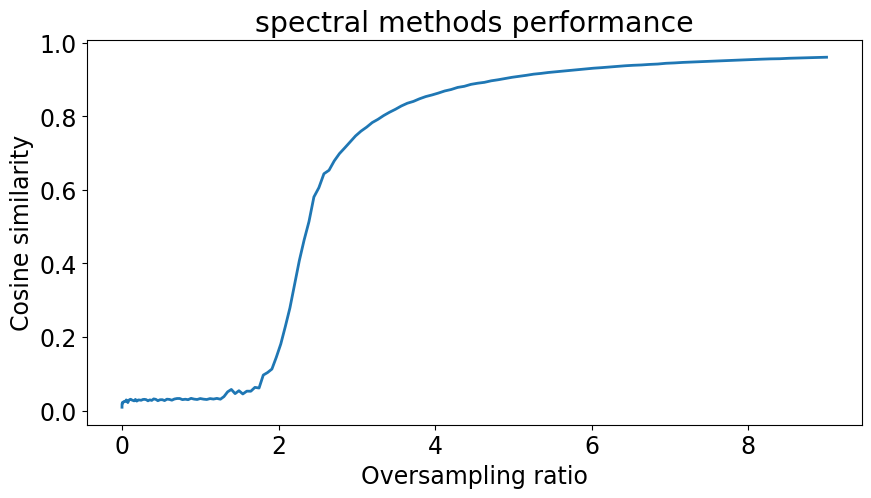

In [23]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("spectral methods performance")
plt.show()

In [24]:
# save results
torch.save(res_spec, SAVE_DIR / "pseudorandom" / "res_spec_3layer.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_spec_3layer.pt")

# Cosine similarity strangely high at 1

In [202]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,1,1),
    dtype=torch.cfloat,
    device=device,
)

In [203]:
y = physics(x_phase)
torch.allclose(physics.B_adjoint(physics.B(x_phase)), x_phase)

False

In [204]:
cosine_similarity(physics.A_adjoint(y, n_iter=2500),x_phase)

tensor(0.6373, device='cuda:0')

In [205]:
x_phase_1 = spectral_methods(y, physics, n_iter=2500)
cosine_similarity(x_phase_1, x_phase)


tensor(0.6404, device='cuda:0')

Image 0, channel 0 does not have a global phase shift.


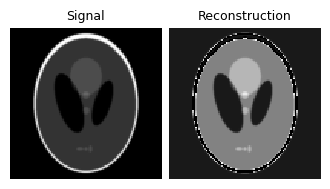

Cosine similarity: tensor(0.4247, device='cuda:0')


In [208]:
# correct possible global phase shifts
x_est = correct_global_phase(x_phase, x_phase_1)
# extract phase information and normalize to the range [0, 1]
x_est = torch.angle(x_est) / 2 / torch.pi
plot([x, x_est],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_est))

# gradient norm w.r.t. oversampling ratios

In [8]:
oversampling_ratios = []
mean_gradient = []

data_fidelity = L2()

for i in tqdm(range(1, 299, 2)):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,i,i),
    dtype=torch.cfloat,
    device=device,
) 
    y = physics(x_phase)
    oversampling_ratios.append(physics.oversampling_ratio.item())
    mean_gradient.append(data_fidelity.grad(physics.A_adjoint(y, n_iter=2500), y, physics).mean().norm().item())

100%|██████████| 149/149 [02:35<00:00,  1.04s/it]


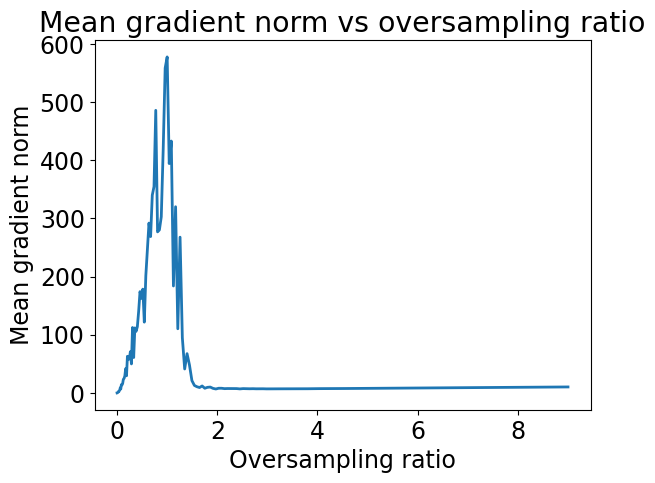

In [9]:
plt.plot(oversampling_ratios, mean_gradient)
plt.xlabel('Oversampling ratio')
plt.ylabel('Mean gradient norm')
plt.title('Mean gradient norm vs oversampling ratio')
plt.show()

# stepsize for oversampling ratio 1

In [19]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,img_size,img_size),
    output_shape=(1,171,171),
    dtype=torch.cfloat,
    device=device,
)

y = physics(x_phase)

In [20]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [21]:
# Algorithm parameters
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
params_algo = {"stepsize": 1e-2, "g_params": 0.00}
#params_algo = {"stepsize": 0.05, "g_params": 0.00}
max_iter = 10000
early_stop = True
verbose = True

/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/envs/deepinv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


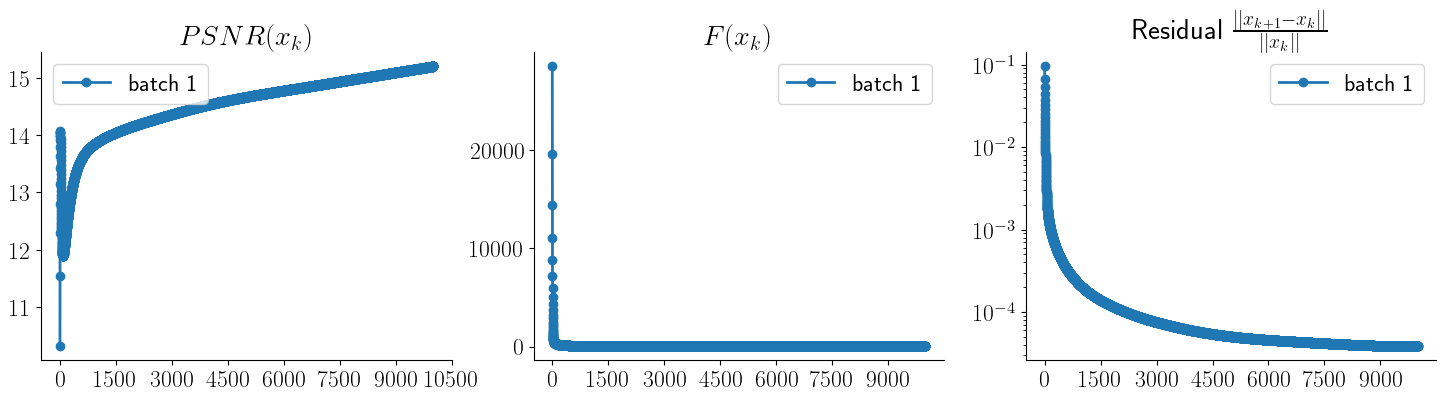

In [22]:
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

# Run the algorithm
x_phase_est, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)
plot_curves(metrics, show=True)

Image 0, channel 0 does not have a global phase shift.


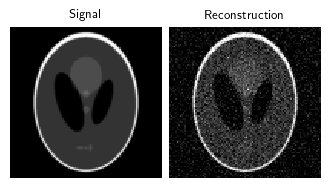

Cosine similarity: tensor(0.9396, device='cuda:0')


In [23]:
# correct possible global phase shifts
x_est = correct_global_phase(x_phase_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_est = torch.angle(x_est) / torch.pi + 0.5
plot([x, x_est],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x_phase, x_phase_est))

# gradient descent with spectral methods for pseudorandom phase retrieval

In [24]:
repeat = 10

# 1-99, 99-141, 141-299
start = 141
end = 299

res_gd_spec = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9 
step_size = 1e-4
# k = 119e-4
# b = -118e-4

In [25]:
def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=2500, **kwargs)
    z = spectral_methods(y, physics, n_iter=2500, **kwargs)
    return {"est": (x, z)}

In [26]:
for i in trange(start,end,2):
    params_algo = {"stepsize": 3e-3*i**2/(99**2), "g_params": 0.00}
    print(params_algo["stepsize"])
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_spec, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_spec[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_spec)

  0%|          | 0/79 [00:00<?, ?it/s]

0.006085399449035813


  1%|▏         | 1/79 [03:19<4:19:52, 199.90s/it]

0.0062592592592592596


In [13]:
oversampling_ratios

tensor([2.0285, 2.0864, 2.1452, 2.2048, 2.2652, 2.3264, 2.3884, 2.4513, 2.5149,
        2.5794, 2.6447, 2.7108, 2.7778, 2.8455, 2.9141, 2.9835, 3.0537, 3.1247,
        3.1965, 3.2692, 3.3426, 3.4169, 3.4920, 3.5679, 3.6446, 3.7222, 3.8005,
        3.8797, 3.9597, 4.0405, 4.1221, 4.2046, 4.2878, 4.3719, 4.4568, 4.5425,
        4.6290, 4.7164, 4.8045, 4.8935, 4.9833, 5.0739, 5.1653, 5.2575, 5.3506,
        5.4444, 5.5391, 5.6346, 5.7309, 5.8281, 5.9260, 6.0248, 6.1244, 6.2248,
        6.3260, 6.4280, 6.5309, 6.6345, 6.7390, 6.8443, 6.9504, 7.0573, 7.1651,
        7.2736, 7.3830, 7.4932, 7.6042, 7.7160, 7.8287, 7.9421, 8.0564, 8.1715,
        8.2874, 8.4041, 8.5217, 8.6400, 8.7592, 8.8792, 9.0000])

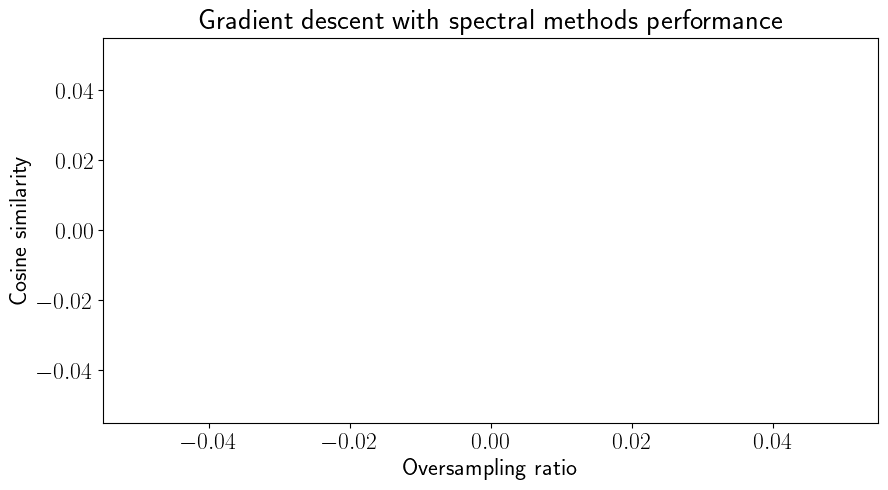

In [ ]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_spec.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with spectral methods performance")
plt.show()

In [181]:
# save results
torch.save(res_gd_spec, SAVE_DIR / "pseudorandom" / "res_gd_spec_1-2.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_1-2.pt")

# Gradient descent with random initialization for pseudorandom phase retrieval

In [126]:
repeat = 10

start = 141
end = 299

res_gd_rand = torch.empty((end-start)//2,repeat)
oversampling_ratios = torch.empty((end-start)//2)

data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True

In [127]:
def random_initialization_wrapper(y, physics, **kwargs):
    x_spec = physics.A_adjoint(y, n_iter=50)
    x = torch.randn_like(x_spec)
    z = torch.randn_like(x_spec)
    return {"est": (x, z)}

In [128]:
for i in trange(start,end,2):
    params_algo = {"stepsize": 0.006*i**2/(img_size**2), "g_params": 0.00}
    model = optim_builder(
        iteration="PGD",
        prior=prior,
        data_fidelity=data_fidelity,
        early_stop=early_stop,
        max_iter=max_iter,
        verbose=verbose,
        params_algo=params_algo,
        custom_init=random_initialization_wrapper,
    )
    for j in range(repeat):
        physics = dinv.physics.PseudoRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, i, i),
            dtype=torch.cfloat,
            device=device,
        )
        y = physics(x_phase)

        oversampling_ratios[(i - start)//2] = physics.oversampling_ratio

        x_phase_gd_rand, _ = model(y, physics, x_gt=x_phase, compute_metrics=True)

        res_gd_rand[(i - start)//2,j] = cosine_similarity(x_phase, x_phase_gd_rand)

 85%|████████▍ | 67/79 [3:03:39<33:26, 167.19s/it]  

Iteration 9363, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7726, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 9674, current converge crit. = 9.99E-06, objective = 1.00E-05 


 86%|████████▌ | 68/79 [3:06:15<30:02, 163.84s/it]

Iteration 5928, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5603, current converge crit. = 9.98E-06, objective = 1.00E-05 


 87%|████████▋ | 69/79 [3:08:42<26:29, 158.95s/it]

Iteration 8506, current converge crit. = 9.97E-06, objective = 1.00E-05 


 89%|████████▊ | 70/79 [3:11:28<24:09, 161.01s/it]

Iteration 9194, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8081, current converge crit. = 1.00E-05, objective = 1.00E-05 


 90%|████████▉ | 71/79 [3:14:06<21:19, 159.98s/it]

Iteration 9341, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7593, current converge crit. = 9.99E-06, objective = 1.00E-05 


 91%|█████████ | 72/79 [3:16:43<18:33, 159.07s/it]

Iteration 9032, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 7590, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8363, current converge crit. = 9.99E-06, objective = 1.00E-05 


 92%|█████████▏| 73/79 [3:19:28<16:05, 161.00s/it]

Iteration 9819, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 6719, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8767, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8118, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 8285, current converge crit. = 9.98E-06, objective = 1.00E-05 


 94%|█████████▎| 74/79 [3:22:03<13:16, 159.27s/it]

Iteration 7312, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 8301, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7729, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 9307, current converge crit. = 9.97E-06, objective = 1.00E-05 


 95%|█████████▍| 75/79 [3:24:30<10:21, 155.40s/it]

Iteration 8066, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 5727, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 7243, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8747, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6499, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6172, current converge crit. = 9.98E-06, objective = 1.00E-05 


 96%|█████████▌| 76/79 [3:26:49<07:31, 150.55s/it]

Iteration 8323, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7422, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 5379, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5222, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 9993, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7409, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 8087, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 9859, current converge crit. = 9.97E-06, objective = 1.00E-05 


 97%|█████████▋| 77/79 [3:28:58<04:48, 144.17s/it]

Iteration 6346, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8356, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6031, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7785, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 5261, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 6087, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 7145, current converge crit. = 9.98E-06, objective = 1.00E-05 


 99%|█████████▊| 78/79 [3:31:14<02:21, 141.75s/it]

Iteration 9141, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 7871, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8976, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 5669, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 4525, current converge crit. = 9.97E-06, objective = 1.00E-05 
Iteration 5402, current converge crit. = 9.98E-06, objective = 1.00E-05 
Iteration 8236, current converge crit. = 9.99E-06, objective = 1.00E-05 
Iteration 9241, current converge crit. = 1.00E-05, objective = 1.00E-05 
Iteration 5563, current converge crit. = 9.98E-06, objective = 1.00E-05 


100%|██████████| 79/79 [3:33:12<00:00, 161.94s/it]

Iteration 8412, current converge crit. = 1.00E-05, objective = 1.00E-05 


In [158]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_gd_rand.mean(dim=1))
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.title("Gradient descent with random initialization performance")
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

<Figure size 1000x500 with 0 Axes>

In [131]:
# save results
torch.save(res_gd_rand, SAVE_DIR / "pseudorandom" / "res_gd_rand_2-9.pt")
torch.save(oversampling_ratios, SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_2-9.pt")

# overall visualization

In [161]:
print(SAVE_DIR)

data/20240609-084948


In [162]:
oversampling_ratios = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_spec.pt")

ratio_1 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_0-1.pt")
ratio_2 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_1-2.pt")
ratio_3 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_spec_2-9.pt")

ratio_4 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_0-2.pt")
ratio_5 = torch.load(SAVE_DIR / "pseudorandom" / "oversampling_ratios_gd_rand_2-9.pt")

In [163]:
oversampling_ratios.shape

torch.Size([149])

In [164]:
torch.concatenate((ratio_4, ratio_5)) == oversampling_ratios

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True])

In [165]:
res_gd_rand_0_2 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_rand_0-2.pt")
res_gd_rand_2_9 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_rand_2-9.pt")
res_gd_rand = torch.concatenate((res_gd_rand_0_2.mean(dim=1), res_gd_rand_2_9.mean(dim=1)))
res_gd_rand.shape

torch.Size([149])

In [166]:
res_gd_spec_0_1 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_0-1.pt")
res_gd_spec_1_2 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_1-2.pt")
res_gd_spec_2_9 = torch.load(SAVE_DIR / "pseudorandom" / "res_gd_spec_2-9.pt")
res_gd_spec = torch.concatenate((res_gd_spec_0_1.mean(dim=1), res_gd_spec_1_2.mean(dim=1), res_gd_spec_2_9.mean(dim=1)))
res_gd_spec.shape

torch.Size([149])

In [167]:
res_gd_spec

tensor([0.7548, 0.0159, 0.0192, 0.0202, 0.0219, 0.0254, 0.0259, 0.0303, 0.0271,
        0.0287, 0.0325, 0.0390, 0.0348, 0.0369, 0.0361, 0.0425, 0.0463, 0.0374,
        0.0352, 0.0472, 0.0532, 0.0480, 0.0557, 0.0530, 0.0593, 0.0577, 0.0612,
        0.0628, 0.0568, 0.0549, 0.0660, 0.0688, 0.0745, 0.0733, 0.0829, 0.0722,
        0.0867, 0.0870, 0.0939, 0.1058, 0.0969, 0.1070, 0.0878, 0.1015, 0.1160,
        0.1007, 0.1178, 0.1242, 0.1399, 0.1538, 0.0110, 0.0084, 0.0163, 0.0256,
        0.0330, 0.0361, 0.0584, 0.0645, 0.0600, 0.0704, 0.0943, 0.1000, 0.1167,
        0.1268, 0.1491, 0.1720, 0.1997, 0.1979, 0.2304, 0.2767,    nan, 0.2815,
        0.3150, 0.3624, 0.3887, 0.4367, 0.4961, 0.5342, 0.5985, 0.6194, 0.6878,
        0.7287, 0.7873, 0.8446, 0.9026, 0.9961, 0.9997, 0.9998, 0.9998, 0.9998,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [168]:
res_spec = torch.load(SAVE_DIR / "pseudorandom" / "res_spec.pt").mean(dim=1)
res_spec.shape

torch.Size([149])

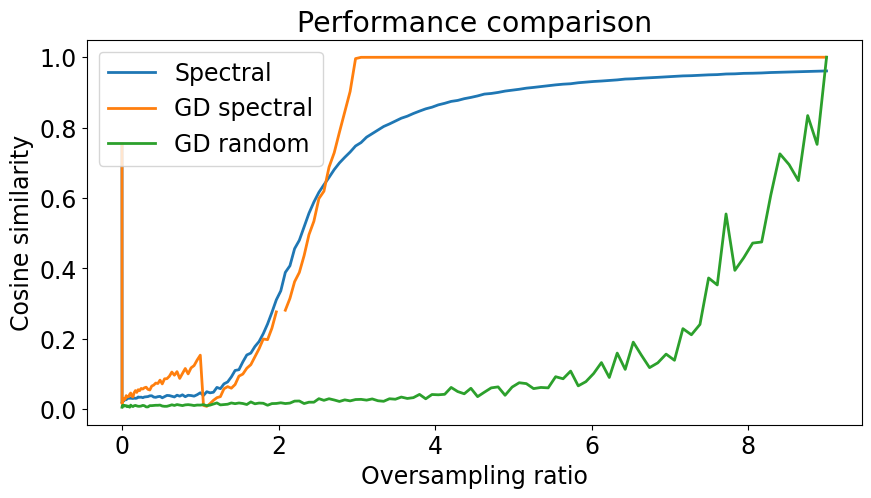

In [177]:
plt.figure(figsize=(10, 5))
plt.plot(oversampling_ratios, res_spec, label="Spectral")
plt.plot(oversampling_ratios, res_gd_spec, label="GD spectral")
plt.plot(oversampling_ratios, res_gd_rand, label="GD random")
plt.xlabel("Oversampling ratio")
plt.ylabel("Cosine similarity")
plt.legend(loc="upper left")
plt.title("Performance comparison")
plt.show()

# single pixel

In [44]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,99,99),
    output_shape=(1,1,1),
    dtype=torch.cfloat,
    device=device,
)

In [65]:
y = physics(x_phase)
y

tensor([[[[1.1515]]]], device='cuda:0')

In [66]:
x_phase_est = spectral_methods(y, physics, n_iter=2500)
cosine_similarity(x_phase_est, x_phase)

tensor(0.0051, device='cuda:0')

In [67]:
x_phase_est

tensor([[[[-0.0108-0.0180j,  0.0095+0.0019j,  0.0035-0.0050j,  ...,
           -0.0115+0.0020j, -0.0064-0.0059j,  0.0137+0.0039j],
          [ 0.0015-0.0062j, -0.0075+0.0084j,  0.0022+0.0047j,  ...,
           -0.0029+0.0077j, -0.0080+0.0136j, -0.0058-0.0057j],
          [ 0.0005+0.0022j,  0.0044-0.0012j, -0.0078-0.0061j,  ...,
            0.0105-0.0109j,  0.0059-0.0077j, -0.0044+0.0008j],
          ...,
          [-0.0035+0.0088j, -0.0036+0.0048j,  0.0006+0.0021j,  ...,
           -0.0070-0.0064j,  0.0060-0.0020j,  0.0011+0.0004j],
          [-0.0047+0.0003j, -0.0010+0.0079j,  0.0004+0.0054j,  ...,
           -0.0042-0.0002j, -0.0001+0.0079j,  0.0075+0.0045j],
          [ 0.0060-0.0048j, -0.0012+0.0062j,  0.0107+0.0032j,  ...,
           -0.0002-0.0047j, -0.0101+0.0042j, -0.0018-0.0010j]]]],
       device='cuda:0')

In [68]:
y = y / torch.mean(y)
diag_T = default_preprocessing(y, physics)
diag_T

tensor([[[[0.]]]], device='cuda:0')

In [78]:
x0 = torch.randn((y.shape[0],) + physics.img_shape, dtype=physics.dtype, device=physics.device)
x_back = x0
x0 = x0.to(torch.cfloat)
x0 = x0 / torch.linalg.norm(x0)
# y should have mean 1
y = y / torch.mean(y)
diag_T = default_preprocessing(y, physics)
diag_T = diag_T.to(torch.cfloat)
diag_T

tensor([[[[0.+0.j]]]], device='cuda:0')

Image 0, channel 0 does not have a global phase shift.


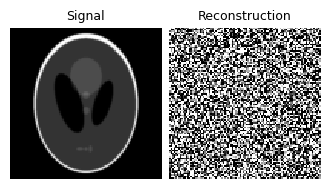

Cosine similarity: tensor(0.3413, device='cuda:0')


In [79]:
# correct possible global phase shifts
x_est = correct_global_phase(x0, x_phase)
# extract phase information and normalize to the range [0, 1]
x_est = torch.angle(x_est) / torch.pi + 0.5
plot([x, x_est],titles=["Signal","Reconstruction"],rescale_mode='clip')
print("Cosine similarity:", cosine_similarity(x, x_est))

In [80]:
cosine_similarity(x_phase, x0)

tensor(0.0149, device='cuda:0')

In [119]:
# x0 remains unchanged since res is zero
res = physics.B(x0)
res = diag_T * res
res = physics.B_adjoint(res)
x0 = res + 10 * x0
x0 = x0 / torch.linalg.norm(x0)
x0

tensor([[[[-0.0053+4.5582e-03j,  0.0035+4.0917e-03j, -0.0148+2.6619e-03j,
            ...,  0.0073+2.2922e-03j,  0.0017-6.7528e-03j,
            0.0047+5.5538e-03j],
          [-0.0072+5.3858e-03j, -0.0115-2.7621e-03j, -0.0026-3.8836e-03j,
            ...,  0.0006-6.6913e-03j,  0.0031+1.5228e-03j,
            0.0071+7.9568e-03j],
          [ 0.0060-2.9792e-03j,  0.0162+6.9526e-03j,  0.0119+9.3159e-03j,
            ...,  0.0039-5.4588e-03j, -0.0002+3.2398e-04j,
           -0.0060-3.7518e-03j],
          ...,
          [-0.0034-8.5705e-04j,  0.0082-9.1327e-04j,  0.0060+2.1268e-03j,
            ...,  0.0052+9.5109e-03j, -0.0075-2.9431e-03j,
            0.0062+7.2078e-05j],
          [-0.0119-3.9723e-03j, -0.0077+4.9304e-03j, -0.0069+2.3437e-03j,
            ...,  0.0061-7.5178e-03j,  0.0167+8.6387e-03j,
            0.0015+7.2826e-04j],
          [-0.0050-3.6687e-03j, -0.0064-1.1242e-02j, -0.0038-6.5699e-03j,
            ..., -0.0027-2.4771e-03j,  0.0067-7.9939e-03j,
            0.0108+7.0

In [18]:
torch.linalg.norm(x0)

tensor(10.0000, device='cuda:0')